In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from unsupervised_random_forest import urf
from sklearn.manifold import MDS
import seaborn as sns

In [2]:
# Change to correct working directory
os.chdir('C:\\Users\\xmste\\OneDrive\\Documents\\Systems Biology\\Year 2\\Scientific Programming\\Project\\SP_squirrels')

# Check working directory
os.getcwd()

'C:\\Users\\xmste\\OneDrive\\Documents\\Systems Biology\\Year 2\\Scientific Programming\\Project\\SP_squirrels'

# Load and explore squirrel dataset
In this section, the squirrel dataset is loaded and various aspects of it are explored.

In [3]:
# Read dataset
squirrels_raw = pd.read_csv('nyc_squirrels.csv')

In [4]:
# Get other activities that are not NaN
pd.set_option('display.max_rows', None) # display all columns

other_activities_notnan = squirrels_raw["Other Activities"][squirrels_raw["Other Activities"].notnull()]

From the entries in Other Activities, it can be seen that squirrels 144 and 2041 are dead. Thus, these squirrels are removed from the dataset.

In [5]:
# Remove dead squirrels from data
squirrels = squirrels_raw.drop([144, 2041])
squirrels.reset_index(drop=True, inplace=True)

# TODO: get data of dead squirrels automatically (so by selecting squirrels that have 'dead' in Other Activities column
# TODO: drop squirrels by unique squirrel ID and not index

In [6]:
## Check if removing dead squirrels was succesful

# Check by seeing if dead squirrels still pop up in 'other activities' that are not NaN
other_activities_notnan_live = squirrels["Other Activities"][squirrels["Other Activities"].notnull()]
# print(other_activities_notnan_live)

# Check by printing shapes of original and cleaned data
print(squirrels_raw.shape)
print(squirrels.shape)

(3023, 31)
(3021, 31)


To know whether foraging behavior is interesting and useable to look at, it is important to know how many squirrels were actually seen foraging, to know if there is enough data available for foraging squirrels.

In [7]:
# Get number of foraging squirrels
squirrels.Foraging.value_counts()

False    1586
True     1435
Name: Foraging, dtype: int64

The same has to be done for other variables, such as checking how many squirrels of every type there are and how many are approaching humans. 

In [8]:
# Get number of squirrels per fur color
squirrels['Primary Fur Color'].value_counts()

Gray        2472
Cinnamon     391
Black        103
Name: Primary Fur Color, dtype: int64

In [9]:
# Get number of approaching squirrels
squirrels['Approaches'].value_counts()

False    2843
True      178
Name: Approaches, dtype: int64

In [10]:
# Get number of squirrels per age
squirrels['Age'].value_counts()

Adult       2566
Juvenile     330
?              4
Name: Age, dtype: int64

In [11]:
# Get number of gray squirrels that are approaching humans
squirrels_gray = squirrels.loc[squirrels['Primary Fur Color'] == 'Gray']

# Calculate proportion of gray squirrels that approached people
squirrels_gray['Approaches'].value_counts().loc[True] / squirrels_gray['Approaches'].value_counts().loc[False]

0.05370843989769821

In [12]:
# Get number of cinnamon squirrels that are approaching humans
squirrels_cinnamon = squirrels.loc[squirrels['Primary Fur Color'] == 'Cinnamon']

# Calculate proportion of gray squirrels that approached people
squirrels_cinnamon['Approaches'].value_counts().loc[True] / squirrels_cinnamon['Approaches'].value_counts().loc[False]

0.12680115273775217

In [13]:
# Get number of black squirrels that are approaching humans
squirrels_black = squirrels.loc[squirrels['Primary Fur Color'] == 'Black']

# Calculate proportion of gray squirrels that approached people
squirrels_black['Approaches'].value_counts().loc[True] / squirrels_black['Approaches'].value_counts().loc[False]

0.061855670103092786

In [14]:
# Get column names
squirrels.columns

Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long'],
      dtype='object')

# Map squirrel locations
In this section, the location of squirrels can be mapped. This can be done for all squirrels or for various subsets of squirrels (e.g. only squirrels that are black, foraging, or something else).

## Map based on hectares into which park has been divided

In [15]:
# TODO: look into dot size (does it now really give a good representation of distribution of squirrels?) 
# TODO: heatmap?

def plot_positions(squirrel_data):
    
    # Get number of squirrels per hectare
    squirrels_per_hectare = squirrel_data['Hectare'].value_counts()
    
    # Create figure
    plt.figure(figsize=(5,10))

    # Loop through hectares and plot dot relative to number of squirrels in that hectare
    # x-positions are saved by their ASCII value

    for hectare, n_squirrels in squirrels_per_hectare.items():
        y_coord = int(hectare[:2])
        x_coord = ord(hectare[2:])
        plt.scatter(x_coord, y_coord, color='blue', s=n_squirrels)
        
    plt.xticks([65, 66, 67, 68, 69, 70, 71, 72, 73], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
    plt.show()

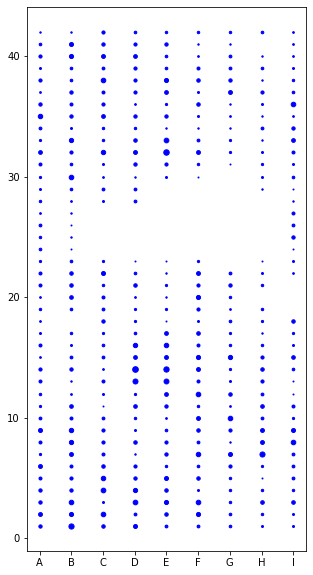

In [16]:
## Examples

# Plot positions of all squirrels
plot_positions(squirrels)

# Plot positions of all approaching gray squirrels
# squirrels_gray = squirrels.loc[squirrels['Primary Fur Color'] == 'Gray']
# plot_positions(squirrels_gray.loc[squirrels_gray['Approaches'] == True])

# Plot positions of all foraging squirrels
# plot_positions(squirrels.loc[squirrels['Foraging'] == True])

# Park dataset

In [17]:
# Load park data
park = pd.read_csv('hectare_data.csv')

# Isolation forest

In [18]:
## Preprocessing

# Select columns to be used in isolation forest
isolation_columns = ['Hectare', 'Shift', 'Age', 'Primary Fur Color', 'Location', 'Running',
                     'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans',
                     'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']

squirrels = squirrels.dropna(subset=isolation_columns)
squirrels.reset_index(drop=True, inplace=True)

# # Select only columns to be used in isolation forest
# squirrels_isolation = squirrels.drop(['X', 'Y', 'Unique Squirrel ID', 'Date', 'Hectare Squirrel Number',
#                                       'Highlight Fur Color',
#                                       'Combination of Primary and Highlight Color', 
#                                       'Color notes', 'Above Ground Sighter Measurement', 
#                                       'Specific Location', 'Other Activities', 'Other Interactions',
#                                       'Lat/Long'], axis=1)
squirrels_isolation = squirrels[isolation_columns]

## With label encoding

In [19]:
# Label encoder
le = LabelEncoder()
squirrels_encoded = squirrels_isolation.apply(lambda col: le.fit_transform(col))    

# Isolation forest
rng = np.random.RandomState(42)
clf = IsolationForest(n_estimators=1000, max_samples='auto', random_state=rng, contamination=0.1)

clf.fit(squirrels_encoded)
pred = clf.predict(squirrels_encoded)
squirrels['anomaly']=pred
outliers=squirrels.loc[squirrels['anomaly']==-1]
outlier_index=list(outliers.index)
print(squirrels['anomaly'].value_counts())

D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    2539
-1     283
Name: anomaly, dtype: int64


<BarContainer object of 2822 artists>

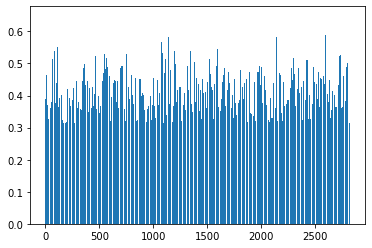

In [20]:
# Calculate isolation scores from IF
scores = clf.decision_function(squirrels_encoded)
original_paper_score = [-1*s + 0.5 for s in scores]

# Plot distribution of isolation scores
plt.bar(x = np.asarray(range(0, len(scores))), height = original_paper_score)

In [21]:
test = pd.DataFrame(scores < 0)
test.value_counts()

False    2539
True      283
dtype: int64

## With one hot encoding

In [22]:
# Create isolation forest
rng = np.random.RandomState(42)
clf_ohe = IsolationForest(max_samples='auto', random_state=rng)

# One-hot encoding of data
squirrels_ohe = pd.get_dummies(squirrels_isolation)
clf_ohe.fit(squirrels_ohe)

# Get number of anomalies predicted by isolation forest
pred = clf_ohe.predict(squirrels_ohe)
squirrels['anomaly']=pred
outliers=squirrels.loc[squirrels['anomaly']==-1]
outlier_index=list(outliers.index)
print(squirrels['anomaly'].value_counts())

1    2822
Name: anomaly, dtype: int64


So with one-hot encoding, there apparently are no outliers, so doing further visualization of that is not very interesting.

# Unsupervised random forest and Multidimensional Scaling

https://jessicastringham.net/2018/05/20/Multidimensional-Scaling/

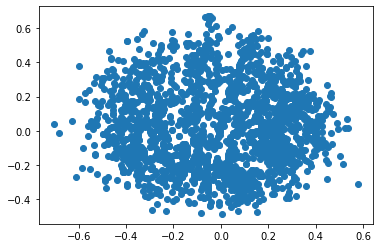

In [23]:
# Get distance matrix from Unsupervised Random Forest
urf_model = urf(n_trees=500, max_depth=3)
distance_mat = urf_model.get_distance(squirrels_encoded.to_numpy())

# Calculate PC scores from distance matrix using sklearn
embedding = MDS(n_components=2, dissimilarity='precomputed')
PC_scores_MDS = embedding.fit_transform(distance_mat)

PC_scores_MDS = pd.DataFrame(PC_scores_MDS)
plt.scatter(PC_scores_MDS[0], PC_scores_MDS[1])

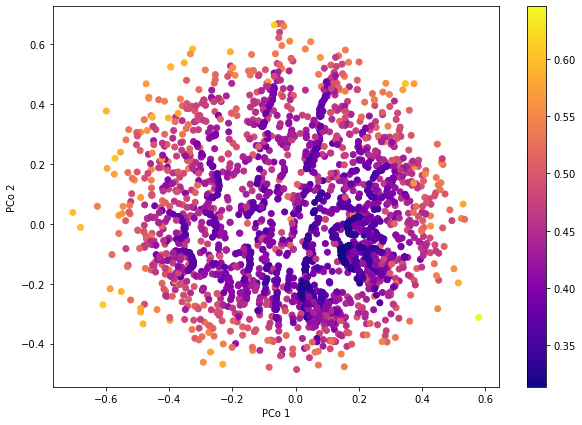

In [46]:
# Color PCoA plots by anomaly score from IF
f, ax = plt.subplots(figsize=(10, 7))
points = ax.scatter(PC_scores_MDS[0], PC_scores_MDS[1], c=original_paper_score, cmap='plasma')
ax.set_xlabel('PCo 1')
ax.set_ylabel('PCo 2')
f.colorbar(points)

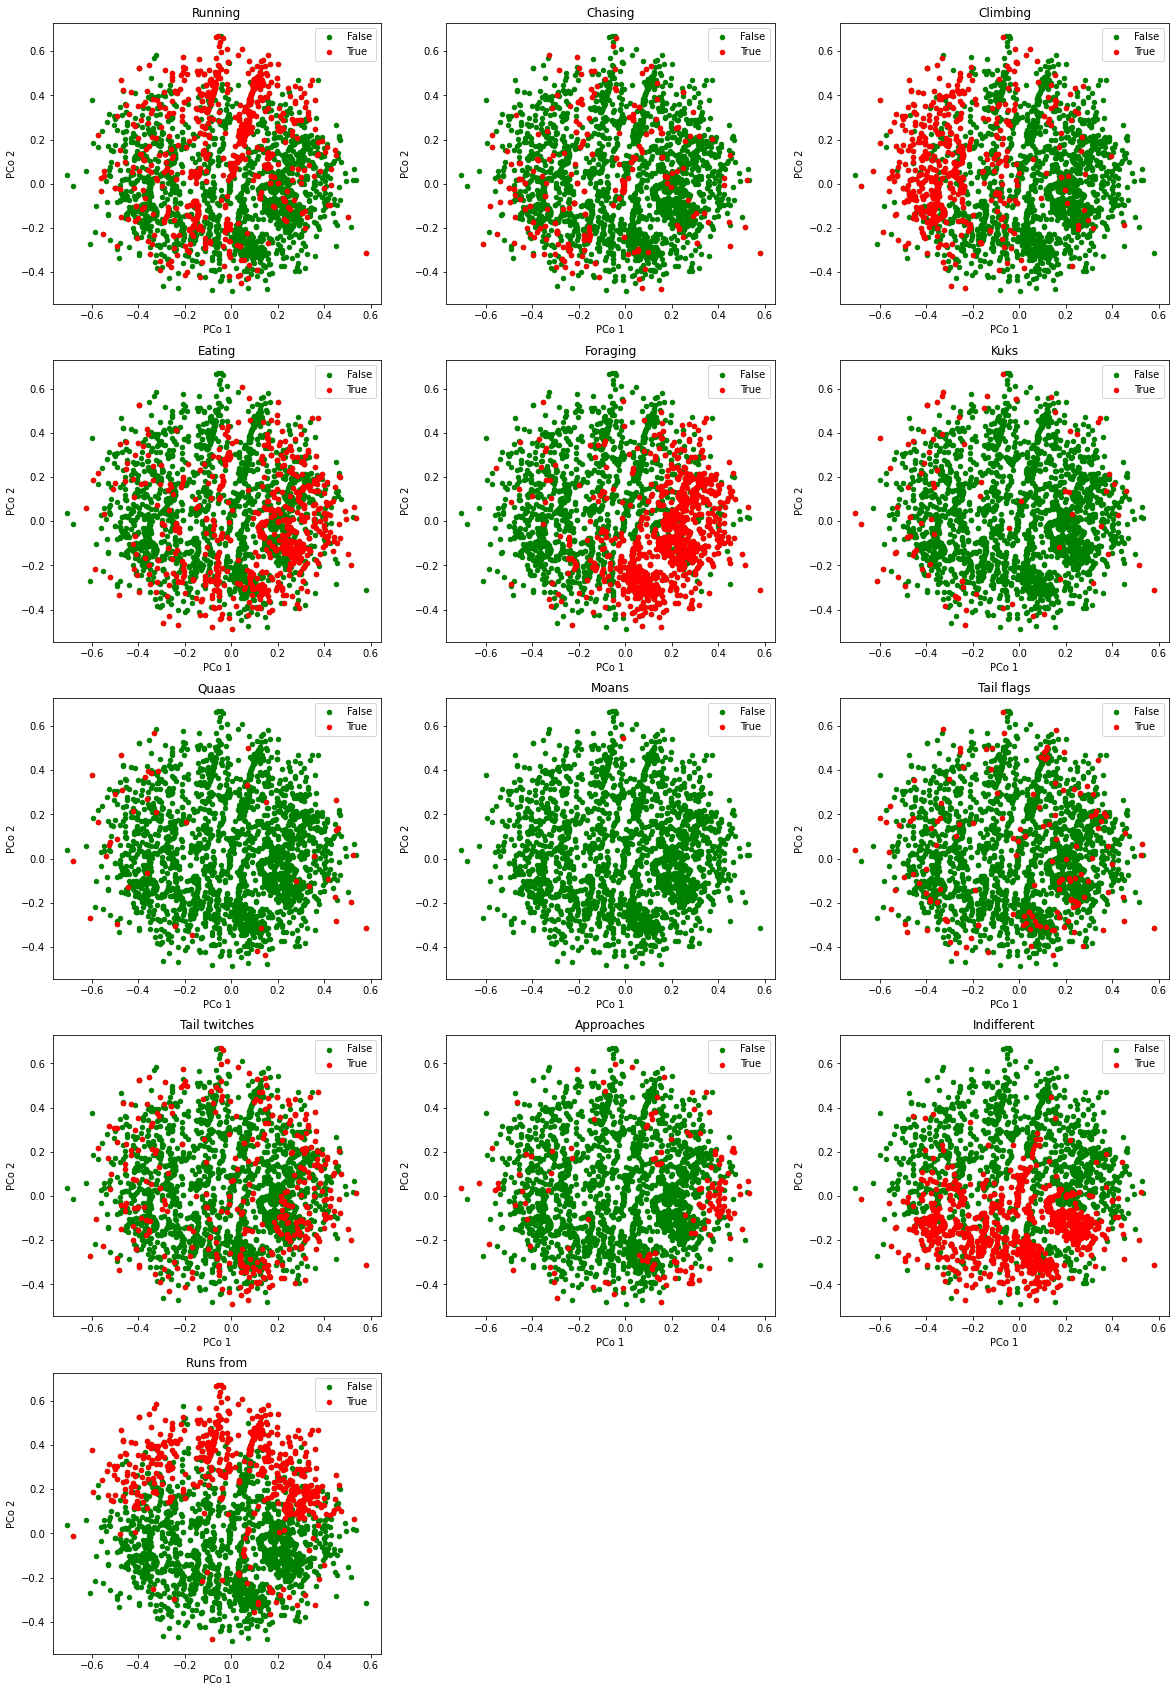

In [43]:
# For boolean variables

bool_vars = ['Running','Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 
             'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']

# Color PC plots by different variables
plt.figure(figsize=(20, 30))
# plt.subplots_adjust(hspace=0.5)

# Make subplots in loop
for n, var in enumerate(bool_vars):
    # add a new subplot iteratively
    ax = plt.subplot(5, 3, n + 1)
    true_ind = squirrels.index[squirrels[var] == True]

    b1 = ax.scatter(PC_scores_MDS[0], PC_scores_MDS[1], c='green', s=20,label="False")
    b1 = ax.scatter(PC_scores_MDS.iloc[true_ind,0],PC_scores_MDS.iloc[true_ind,1], c='red',s=20,label="True")

    # chart formatting
    ax.set_title(var)
    plt.legend(loc="upper right")
    ax.set_xlabel('PCo 1')
    ax.set_ylabel('PCo 2')
    
plt.savefig('PCo_bool_2.png')

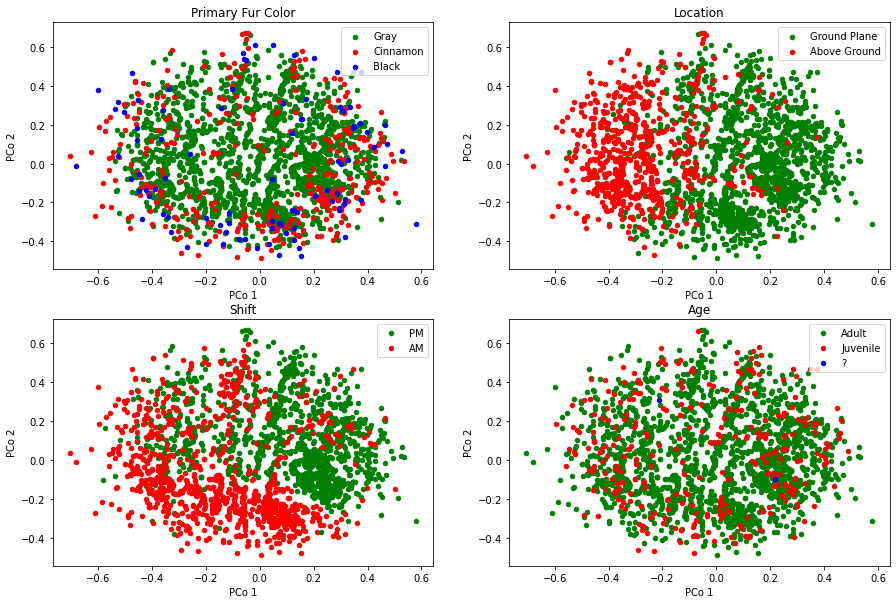

In [26]:
# For non-boolean variables

plot_colors = ['green', 'red', 'blue']
nonbool_vars = ['Primary Fur Color', 'Location', 'Shift', 'Age']

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.2)

for n, nonbool_var in enumerate(nonbool_vars):
    cats = squirrels[nonbool_var].value_counts()
    for (item, n_squirrels), plot_col in zip(cats.items(), plot_colors):
        # add a new subplot iteratively
        ax = plt.subplot(2, 2, n + 1)

        col_ind = squirrels.index[squirrels[nonbool_var] == item]
        ax.scatter(PC_scores_MDS.iloc[col_ind, 0], PC_scores_MDS.iloc[col_ind, 1], c=plot_col, s=20,label=item)

        # chart formatting
        ax.set_title(nonbool_var)
        plt.legend(loc="upper right")
        ax.set_xlabel('PCo 1')
        ax.set_ylabel('PCo 2')

# Stuffs to try
- Use date: check for differences between weekdays and weekend and maybe holidays
- Use park data: maybe map rainy/cloudy days vs sunny days or color dots on map by busyness
- Mapping: look at dot size, maybe adjust, heat map?
- Try LPP: problem is, no idea on what I should do that (encoded data? Distance matrix?)
- Look into meaning of anomaly scores in URF
- Look into tweaking parameters (n_estimators, max_depth) for URF
- Look into function for isolation forest (threshold, n_estimators)
- Look into categorical PCA
- Look what more can be done with distance matrix from URF: kmeans?
- Get explained variance from MDS -> volgens mij kan da nie
- Look into anomaly scores from IF

# Questions

Get distance matrix from URF or IF
Check if matrix is similarity matrix, case if diagonal is 1
If similarity matrix, convert to distance matrix
Double centering on distance matrixprint(skbio.art).